## Identify and Classify Toxic Online Comments

### The dataset
**Data Source** : 1. Toxic Comment Classification dataset on Kaggle 2. Dataset of comments from Wikipedia’s talk page edits.

**Objective** : To build a model to detect different types of toxicity in online comments such as threats, obscenity, insults, and identity-based hate.  

### Multi-headed classification
Here, the objective is to build a multi-headed model that is capable of detecting different types of toxicity like threats, obscenity, insults and identity-based hate. In **multi-headed classification**, data can belong to more than one label simultaneously. For example, in our case a comment may be toxic, obscene, and insulting at the same time. It may also happen that the comment is non-toxic and hence does not belong to any of the six labels.

## 1. Obtaining and Viewing the Data
<a id='1. Obtaining and Viewing the Data' >

The data consist of many Wikipedia comments which have been labelled by humans according to their relative toxicity. It includes the following:

- train.csv - the training set, contains comments with their binary labels
- test.csv - the test set, predicts toxicity probabilities for these comments.
- test_labels.csv - labels for the test data (value of -1 indicates it was not used for scoring)

Starting by loading the training and testing data.

In [1]:
## importing the necessary libraries for visualizaing the data
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
plt.style.use('seaborn')

import seaborn as sns

**1. Test Data**

In [2]:
## Reading the test labels
test_labels = pd.read_csv('test_labels.csv')
print(test_labels.shape)

# The description states *"value of -1 indicates it was not used for scoring"*, so we will drop all of those rows.
test_labels = test_labels[(test_labels[['toxic','severe_toxic', 'obscene', 'threat', 
                                        'insult', 'identity_hate']] != -1).all(axis=1)]
print(test_labels.shape)

## Loading test data
df_test = pd.read_csv('test.csv')
print(df_test.shape)

# The *test comments* and the *test labels* - both in different datasets - differ in their length,
# as we had to drop a substantial amount of rows in the first one. Let's merge both datasets with
# an inner join to keep only the records with a proper label.
# merge with an inner join
test = pd.merge(test_labels, df_test, on='id', how='inner')
print(test.shape)
test.head(2)

(153164, 7)
(63978, 7)
(153164, 2)
(63978, 8)


,id,toxic,severe_toxic,obscene,threat,insult,identity_hate,comment_text
0,0001ea8717f6de06,0,0,0,0,0,0,Thank you for understanding. I think very high...
1,000247e83dcc1211,0,0,0,0,0,0,:Dear god this site is horrible.


**2. Training Data:**

In [3]:
## Loading training data
train = pd.read_csv('train.csv')

# check the number of records
print('The dataset contains', train.shape[0], 'records and', train.shape[1], 'columns.')

# check that there are no missing values in either training set
print('The dataset has', train.isna().sum().sum(), 'missing values.')

# check if there are any duplicates
print('The dataset has', train.duplicated().sum(), 'duplicates.')

The dataset contains 159571 records and 8 columns.
The dataset has 0 missing values.
The dataset has 0 duplicates.


Let's explore some comments:

In [4]:
train['comment_text'][8]

"Sorry if the word 'nonsense' was offensive to you. Anyway, I'm not intending to write anything in the article(wow they would jump on me for vandalism), I'm merely requesting that it be more encyclopedic so one can use it for school as a reference. I have been to the selective breeding page but it's almost a stub. It points to 'animal breeding' which is a short messy article that gives you no info. There must be someone around with expertise in eugenics? 93.161.107.169"

In [5]:
train['comment_text'][13]

"Before you start throwing accusations and warnings at me, lets review the edit itself-making ad hominem attacks isn't going to strengthen your argument, it will merely make it look like you are abusing your power as an admin. \nNow, the edit itself is relevant-this is probably the single most talked about event int he news as of late. His absence is notable, since he is the only living ex-president who did not attend. That's certainly more notable than his dedicating an aircracft carrier. \nI intend to revert this edit, in hopes of attracting the attention of an admin that is willing to look at the issue itself, and not throw accusations around quite so liberally. Perhaps, if you achieve a level of civility where you can do this, we can have a rational discussion on the topic and resolve the matter peacefully."

## 2. Data Visualization

Some visualizations to make familiar with the data.

### Bar Chart

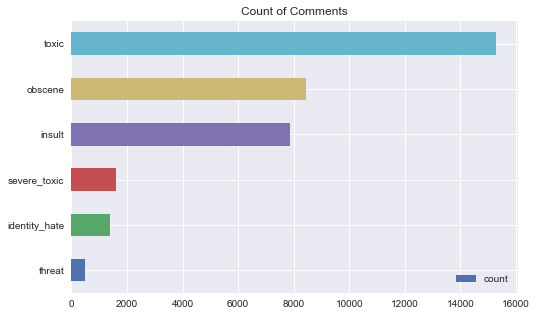

In [6]:
# creating a list of column names
columns = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]

# to_frame() converts series to DataFrame
frequency = train[columns].sum().to_frame().rename(columns={0: 'count'}).sort_values('count')
frequency.plot.barh(y='count', title='Count of Comments', figsize=(8, 5));

The three types of comments that occur most often are:
- toxic comments
- obscene comments
- insulting comments.

In [7]:
# Number of frequent comment combinations:
train.groupby(columns).size().sort_values(ascending=False).reset_index()\
                      .rename(columns={0: 'count'}).head(15)

,toxic,severe_toxic,obscene,threat,insult,identity_hate,count
0,0,0,0,0,0,0,143346
1,1,0,0,0,0,0,5666
2,1,0,1,0,1,0,3800
3,1,0,1,0,0,0,1758
4,1,0,0,0,1,0,1215
5,1,1,1,0,1,0,989
6,1,0,1,0,1,1,618
7,0,0,1,0,0,0,317
8,0,0,0,0,1,0,301
9,1,1,1,0,1,1,265


- Non-toxic comments, i.e. comments which have no label, are clearly ahead with 143346 comments. 
- "Toxic" comments then occur in different combinations within the first 15 ranks. The same holds for "obscene" comments as well as for "insult" comments. 
- The number of comments for each combination drops exponentially. 

### Correlation Matrix

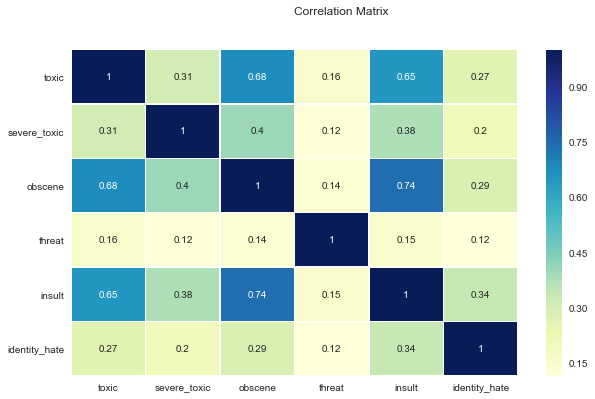

In [8]:
fig, ax = plt.subplots(figsize=(10, 6))
fig.suptitle('Correlation Matrix')
sns.heatmap(train[columns].corr(), annot=True, cmap="YlGnBu", linewidths=.5, ax=ax);

The correlation matrix illuminates interesting relationships :
- "Toxic" comments are clearly correlated with both "obscene" and "insult" comments.
- "toxic" and "severe_toxic" are only weakly correlated.
- "Obscene" comments and "insult" comments are also highly correlated, which makes perfect sense.

### 2.3. Venn Diagrams
<a id='2.3. Venn Diagrams' >

In [12]:
from matplotlib_venn import venn2
from matplotlib_venn import venn3
from matplotlib_venn import venn3_circles
from matplotlib_venn import venn2_circles

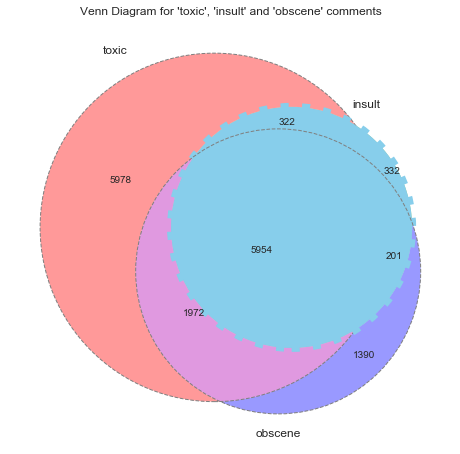

In [13]:
# build combinations
a = train[(train['toxic']==1) & (train['insult']==0) & (train['obscene']==0)].shape[0]
b = train[(train['toxic']==0) & (train['insult']==1) & (train['obscene']==0)].shape[0]
c = train[(train['toxic']==0) & (train['insult']==0) & (train['obscene']==1)].shape[0]

ab = train[(train['toxic']==1) & (train['insult']==1) & (train['obscene']==0)].shape[0]
ac = train[(train['toxic']==1) & (train['insult']==0) & (train['obscene']==1)].shape[0]
bc = train[(train['toxic']==0) & (train['insult']==1) & (train['obscene']==1)].shape[0]

abc = train[(train['toxic']==1) & (train['insult']==1) & (train['obscene']==1)].shape[0]

# plot venn diagrams
plt.figure(figsize=(8, 8))
plt.title("Venn Diagram for 'toxic', 'insult' and 'obscene' comments")

v=venn3(subsets=(a, b, c, ab, ac, bc, abc), 
        set_labels=('toxic', 'insult', 'obscene'))

vc=venn3_circles(subsets=(a, b, c, ab, ac, bc, abc),
                linestyle='dashed', linewidth=1, color="grey")
vc[1].set_lw(8.0)
vc[1].set_ls('dotted')
vc[1].set_color('skyblue')

plt.show();

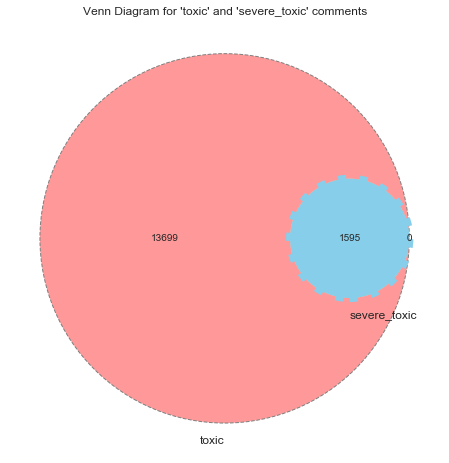

In [14]:
# build combinations
a   = train[(train['toxic']==1) & (train['severe_toxic']==0)].shape[0]
b   = train[(train['toxic']==0) & (train['severe_toxic']==1)].shape[0]
ab = train[(train['toxic']==1) & (train['severe_toxic']==1)].shape[0]

# plot venn diagrams
plt.figure(figsize=(8, 8))
plt.title("Venn Diagram for 'toxic' and 'severe_toxic' comments")
v=venn2(subsets=(a, b, ab), set_labels=('toxic', 'severe_toxic'))

c=venn2_circles(subsets=(a, b, ab),
                linestyle='dashed', linewidth=1, color="grey")
c[1].set_lw(8.0)
c[1].set_ls('dotted')
c[1].set_color('skyblue')

plt.show();

### Word Clouds
We'll use Word Clouds for a better understanding of the differences and similarities between the different categories.

In [15]:
# Libraries
from wordcloud import WordCloud
from collections import Counter

import re
import string

from nltk.corpus import stopwords
stop = stopwords.words('english')

In [16]:
# We define an empty dictionary
word_counter = {}

# Clean_text function
def clean_text(text):
    text = re.sub('[{}]'.format(string.punctuation), ' ', text.lower())
    return ' '.join([word for word in text.split() if word not in (stop)])

In [17]:
# Iterating through all columns in the dataset
for col in columns:    
    text = Counter()        
    
    # applying the clean-function to each column's comments and
    train[train[col] == 1]['comment_text'].apply(lambda t: text.update(clean_text(t).split()))
    
    # combining all to one dataframe
    word_counter[col] = pd.DataFrame.from_dict(text, orient='index')\
                                        .rename(columns={0: 'count'})\
                                        .sort_values('count', ascending=False)

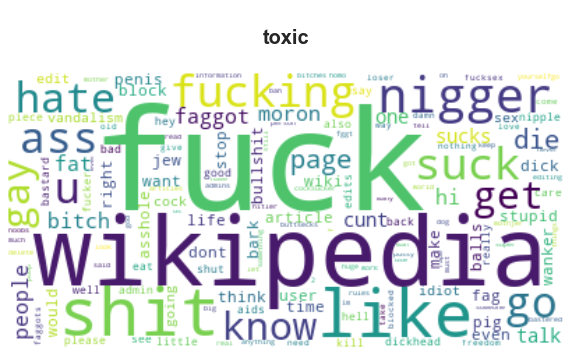

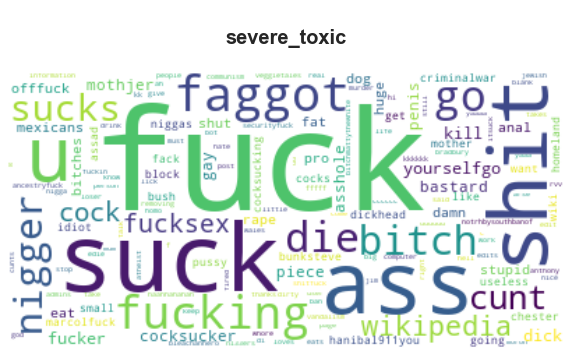

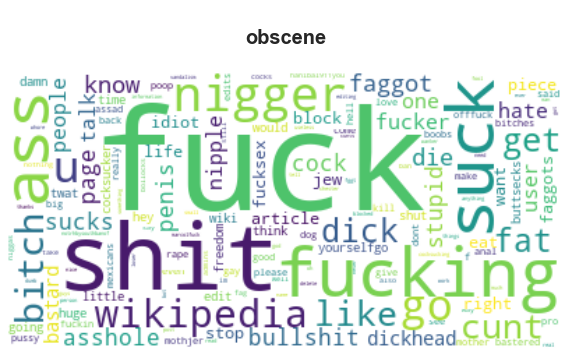

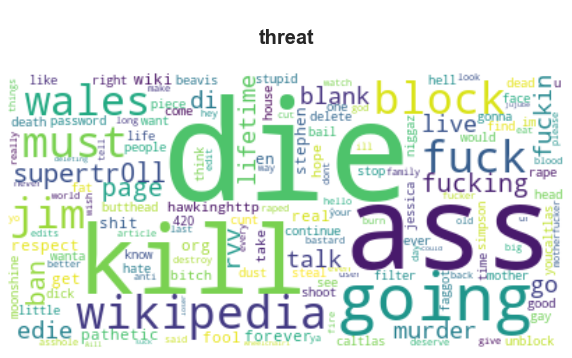

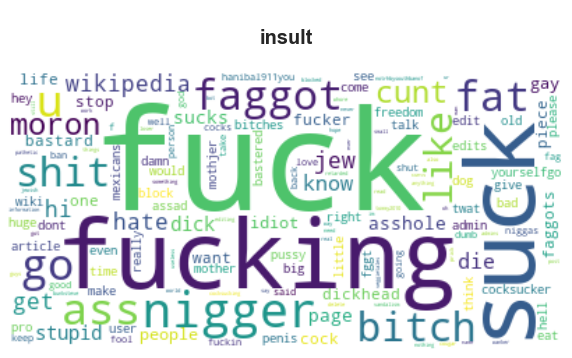

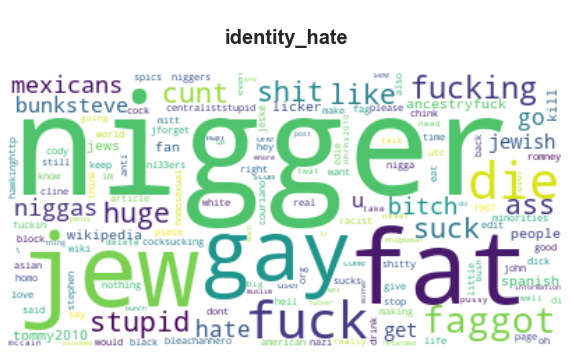

In [18]:
# Iterating through new df word_counter and creating a WordCloud for each column
for col in word_counter:    
    wc_list = word_counter[col]
    
    wordcloud = WordCloud(background_color='white', max_words=150, max_font_size=100, random_state=4)\
                          .generate_from_frequencies(wc_list.to_dict()['count'])

    fig = plt.figure(figsize=(10, 8))
    plt.title('\n' + col + '\n', fontsize=20, fontweight='bold')
    plt.imshow(wordcloud, interpolation = 'bilinear')
    plt.axis('off')
    plt.show()

## Data Preprocessing

To convert our text to vectors, we use Keras's preprocessing tools to **tokenize** each example, convert it to a **sequence**, and then **pad the sequences** so they're all the same length.

In [19]:
# importing libraries
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing import text, sequence

Using TensorFlow backend.


In [20]:
X_train = train["comment_text"].values
X_test  = test["comment_text"].values

y_train = train[["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]].values
y_test  = test[["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]].values

In [21]:
# tokenizing the data
tokenizer = Tokenizer(num_words=20000)
tokenizer.fit_on_texts(list(X_train))

# turning the tokenized text into sequences
X_train = tokenizer.texts_to_sequences(X_train)
X_test  = tokenizer.texts_to_sequences(X_test)

# padding the sequences
X_train = sequence.pad_sequences(X_train, maxlen=200)
X_test  = sequence.pad_sequences(X_test,  maxlen=200)

print('X_train shape:', X_train.shape)
print('X_test shape: ', X_test.shape)

X_train shape: (159571, 200)
X_test shape:  (63978, 200)


## 4. Evaluating Different Neural Networks

First we import some necessary **Keras libraries**

In [24]:
from keras import initializers, regularizers, constraints, optimizers, layers
from keras.models import Model, Input, Sequential
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, SpatialDropout1D, Activation
from keras.layers import Conv1D, Bidirectional, GlobalMaxPool1D, MaxPooling1D, BatchNormalization
from keras.optimizers import Adam

**Model parameters**.

In [25]:
# number of unique words we want to use (or: number of rows in incoming embedding vector)
max_features = 20000 

# max number of words in a comment to use (or: number of columns in incoming embedding vector)
max_len = 200 

# dimension of the embedding variable (or: number of rows in output of embedding vector)
embedding_dims = 128

### Convolutional Neural Network (CNN)

CNN setup

In [26]:
# instantiate CNN model
cnn_model = Sequential()

# add embedding layer 
cnn_model.add(Embedding(input_dim=max_features, input_length=max_len,
                        output_dim=embedding_dims))
 
# set the dropout layer to drop out 50% of the nodes
cnn_model.add(SpatialDropout1D(0.5))

# add convolutional layer that has ...
# ... 100 filters with a kernel size of 4 so that each convolution will consider a window of 4 word embeddings
cnn_model.add(Conv1D(filters=100, kernel_size=4, padding='same', activation='relu'))

# add normalization layer
cnn_model.add(BatchNormalization())

# add pooling layer 
cnn_model.add(GlobalMaxPool1D())

# set the dropout layer to drop out 50% of the nodes
cnn_model.add(Dropout(0.5))

# add dense layer to produce an output dimension of 50 and using relu activation
cnn_model.add(Dense(50, activation='relu'))

# finally add a dense layer
cnn_model.add(Dense(6, activation='sigmoid'))





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [27]:
cnn_model.compile(loss='binary_crossentropy',
                  optimizer=Adam(0.01),
                  metrics=['accuracy'])

cnn_model.summary()



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 200, 128)          2560000   
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 200, 128)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 200, 100)          51300     
_________________________________________________________________
batch_normalization_1 (Batch (None, 200, 100)          400       
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 100)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
______________________________________________

In [28]:
cnn_hist = cnn_model.fit(X_train, y_train, batch_size=32, 
                         epochs=3, validation_split=0.1)




Train on 143613 samples, validate on 15958 samples
Epoch 1/3





143613/143613 [==============================] - 473s 3ms/step - loss: 0.0736 - acc: 0.9757 - val_loss: 0.0589 - val_acc: 0.9799
Epoch 2/3
143613/143613 [==============================] - 479s 3ms/step - loss: 0.0565 - acc: 0.9799 - val_loss: 0.0544 - val_acc: 0.9804
Epoch 3/3
143613/143613 [==============================] - 525s 4ms/step - loss: 0.0536 - acc: 0.9808 - val_loss: 0.0531 - val_acc: 0.9808


In [29]:
cnn_test_loss, cnn_test_auc = cnn_model.evaluate(X_test, y_test, batch_size=32)
print('Test Loss:    ', cnn_test_loss)
print('Test Accuracy:', cnn_test_auc)

63978/63978 [==============================] - 37s 576us/step
Test Loss:     0.07606629090853372
Test Accuracy: 0.968892941316088


### Recurrent Neural Network (RNN)

In [30]:
# instantiate RNN model
rnn_model = Sequential()

# add embedding layer 
rnn_model.add(Embedding(input_dim=max_features, input_length=max_len,
                        output_dim=embedding_dims))

# set the dropout layer to drop out 50% of the nodes
rnn_model.add(SpatialDropout1D(0.5))

# add bidirectional layer and pass in an LSTM()
rnn_model.add(Bidirectional(LSTM(25, return_sequences=True)))

# add normalization layer
rnn_model.add(BatchNormalization())

# add pooling layer 
rnn_model.add(GlobalMaxPool1D())

# set the dropout layer to drop out 50% of the nodes
rnn_model.add(Dropout(0.5))

# add dense layer to produce an output dimension of 50 and using relu activation
rnn_model.add(Dense(50, activation='relu'))

# finally add a dense layer
rnn_model.add(Dense(6, activation='sigmoid'))

In [31]:
rnn_model.compile(loss='binary_crossentropy',
                  optimizer=Adam(0.01),
                  metrics=['accuracy'])

rnn_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 200, 128)          2560000   
_________________________________________________________________
spatial_dropout1d_2 (Spatial (None, 200, 128)          0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 200, 50)           30800     
_________________________________________________________________
batch_normalization_2 (Batch (None, 200, 50)           200       
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 50)                0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 50)                2550      
__________

In [32]:
rnn_hist = rnn_model.fit(X_train, y_train, batch_size=32, 
                          epochs=3, validation_split=0.1)

Train on 143613 samples, validate on 15958 samples
Epoch 1/3
143613/143613 [==============================] - 1125s 8ms/step - loss: 0.0698 - acc: 0.9770 - val_loss: 0.0570 - val_acc: 0.9804
Epoch 2/3
143613/143613 [==============================] - 1065s 7ms/step - loss: 0.0605 - acc: 0.9792 - val_loss: 0.0569 - val_acc: 0.9808
Epoch 3/3
143613/143613 [==============================] - 1277s 9ms/step - loss: 0.0607 - acc: 0.9792 - val_loss: 0.0577 - val_acc: 0.9805


We face a slight increase in validation accuracy!

In [ ]:
rnn_test_loss, rnn_test_auc = rnn_model.evaluate(X_test, y_test, batch_size=32)
print('Test Loss:    ', rnn_test_loss)
print('Test Accuracy:', rnn_test_auc)

53184/63978 [=======================>......] - ETA: 17s

## 5. Results

In [42]:
# concat all training, validation and testing accuracy scores
accuracy_cnn = ['CNN', 
                np.mean(cnn_hist.history['acc']), 
                np.mean(cnn_hist.history['val_acc']), 
                cnn_test_auc]

accuracy_rnn = ['RNN', 
                np.mean(rnn_hist.history['acc']), 
                np.mean(rnn_hist.history['val_acc']), 
                rnn_test_auc]

# create dataframe
comparison = pd.DataFrame([accuracy_cnn])
# append all other scores
comparison = comparison.append([accuracy_rnn])

# modifying new dataframe
comparison.columns = ['Algorithm', 'Training Accuracy', 'Validation Accuracy', 'Testing Accuracy']
comparison.set_index(['Algorithm'], inplace=True)
comparison

,Training Accuracy,Validation Accuracy,Testing Accuracy
Algorithm,,,
CNN,0.978800,0.980372,0.968893
RNN,0.978478,0.980539,0.973718


- We got small differences between the two models.
- When we look at the **training accuracy**, the **CNN** performs best.
- When we check the **validation accuracy**, the **RNN** that stands out.
- But when we check how well the models classify unseen data - and therefore check the **testing accuracy**, it's the **RNN** that does this job with the highest precision.